<a href="https://colab.research.google.com/github/HongJaeKwon/machine-learning/blob/master/HJK_DDPG_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import gym
import numpy as np
import collections
import random

In [2]:
import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np


class ContinuousCartPoleEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 30.0
        self.tau = 0.02  # seconds between state updates
        self.min_action = -1.0
        self.max_action = 1.0
        self.max_score=300
        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds
        high = np.array([
            self.x_threshold * 2,
            np.finfo(np.float32).max,
            self.theta_threshold_radians * 2,
            np.finfo(np.float32).max])

        self.action_space = spaces.Box(
            low=self.min_action,
            high=self.max_action,
            shape=(1,)
        )
        self.observation_space = spaces.Box(-high, high)

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def stepPhysics(self, force):
        x, x_dot, theta, theta_dot = self.state
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / \
            (self.length * (4.0/3.0 - self.masspole * costheta * costheta / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass
        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc
        return (x, x_dot, theta, theta_dot)

    def step(self, action):
        assert self.action_space.contains(action), \
            "%r (%s) invalid" % (action, type(action))
        # Cast action to float to strip np trappings
        force = self.force_mag * float(action)
        self.state = self.stepPhysics(force)
        x, x_dot, theta, theta_dot = self.state
        done = x < -self.x_threshold \
            or x > self.x_threshold \
            or theta < -self.theta_threshold_radians \
            or theta > self.theta_threshold_radians
        done = bool(done)
        
        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn("""
You are calling 'step()' even though this environment has already returned
done = True. You should always call 'reset()' once you receive 'done = True'
Any further steps are undefined behavior.
                """)
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state), reward, done, {}

    def reset(self):
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.x_threshold * 2
        scale = screen_width /world_width
        carty = 100  # TOP OF CART
        polewidth = 10.0
        polelen = scale * 1.0
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            l, r, t, b = -polewidth / 2, polewidth / 2, polelen-polewidth / 2, -polewidth / 2
            pole = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            pole.set_color(.8, .6, .4)
            self.poletrans = rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            self.axle = rendering.make_circle(polewidth / 2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(.5, .5, .8)
            self.viewer.add_geom(self.axle)
            self.track = rendering.Line((0, carty), (screen_width, carty))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

        if self.state is None:
            return None

        x = self.state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(-x[2])

        return self.viewer.render(return_rgb_array=(mode == 'rgb_array'))

    def close(self):
        if self.viewer:
            self.viewer.close()

In [3]:
env = ContinuousCartPoleEnv()
# problem = "Pendulum-v0"
# env = gym.make(problem)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
# 2 - 액션 종류 슈 (아웃풋)
action_num=1
# 4 - 상태 종류 수 (인풋)
state_num=env.observation_space.shape[0]

In [5]:
i = tf.keras.layers.Input(shape=(state_num,))
out = tf.keras.layers.Dense(32, activation="relu")(i)
out = tf.keras.layers.BatchNormalization()(out)
out = tf.keras.layers.Dense(32, activation="relu")(out)
out = tf.keras.layers.BatchNormalization()(out)
out = tf.keras.layers.Dense(action_num, activation="tanh")(out)
u_model = tf.keras.Model(inputs=[i], outputs=[out])

i = tf.keras.layers.Input(shape=(state_num,))
out = tf.keras.layers.Dense(32, activation="relu")(i)
out = tf.keras.layers.BatchNormalization()(out)
out = tf.keras.layers.Dense(32, activation="relu")(out)
out = tf.keras.layers.BatchNormalization()(out)
out = tf.keras.layers.Dense(action_num, activation="tanh")(out)
t_u_model = tf.keras.Model(inputs=[i], outputs=[out])

In [19]:
i = tf.keras.layers.Input(shape=(state_num,))
out = tf.keras.layers.Dense(4, activation="relu")(i)
out = tf.keras.layers.BatchNormalization()(out)
out = tf.keras.layers.Dense(8, activation="relu")(out)
out = tf.keras.layers.BatchNormalization()(out)

a_i = tf.keras.layers.Input(shape=(action_num,))
a_out = tf.keras.layers.Dense(8, activation="relu")(a_i)
a_out = tf.keras.layers.BatchNormalization()(a_out)

out = tf.keras.layers.Concatenate()([out, a_out])

out = tf.keras.layers.Dense(32, activation="relu")(out)
out = tf.keras.layers.BatchNormalization()(out)
out = tf.keras.layers.Dense(32, activation="relu")(out)
out = tf.keras.layers.BatchNormalization()(out)
out = tf.keras.layers.Dense(1)(out)

q_model = tf.keras.Model([i, a_i], out)

i = tf.keras.layers.Input(shape=(state_num,))
out = tf.keras.layers.Dense(4, activation="relu")(i)
out = tf.keras.layers.BatchNormalization()(out)
out = tf.keras.layers.Dense(8, activation="relu")(out)
out = tf.keras.layers.BatchNormalization()(out)

a_i = tf.keras.layers.Input(shape=(action_num,))
a_out = tf.keras.layers.Dense(8, activation="relu")(a_i)
a_out = tf.keras.layers.BatchNormalization()(a_out)

out = tf.keras.layers.Concatenate()([out, a_out])

out = tf.keras.layers.Dense(32, activation="relu")(out)
out = tf.keras.layers.BatchNormalization()(out)
out = tf.keras.layers.Dense(32, activation="relu")(out)
out = tf.keras.layers.BatchNormalization()(out)
out = tf.keras.layers.Dense(1)(out)

t_q_model = tf.keras.Model([i, a_i], out)

In [20]:
t_u_model.set_weights(u_model.get_weights())
t_q_model.set_weights(q_model.get_weights())

In [21]:
opt=tf.keras.optimizers.Adam(0.001,clipnorm=0.1)

In [22]:
opt_2=tf.keras.optimizers.Adam(0.002,clipnorm=0.1)

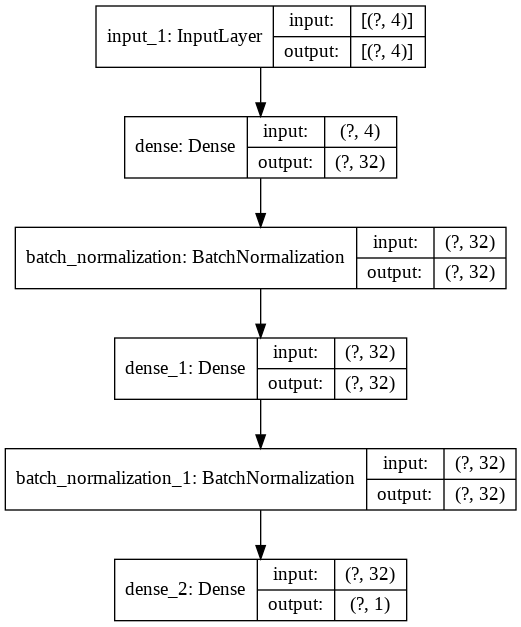

In [14]:
tf.keras.utils.plot_model(u_model,show_shapes=True,show_layer_names=True)

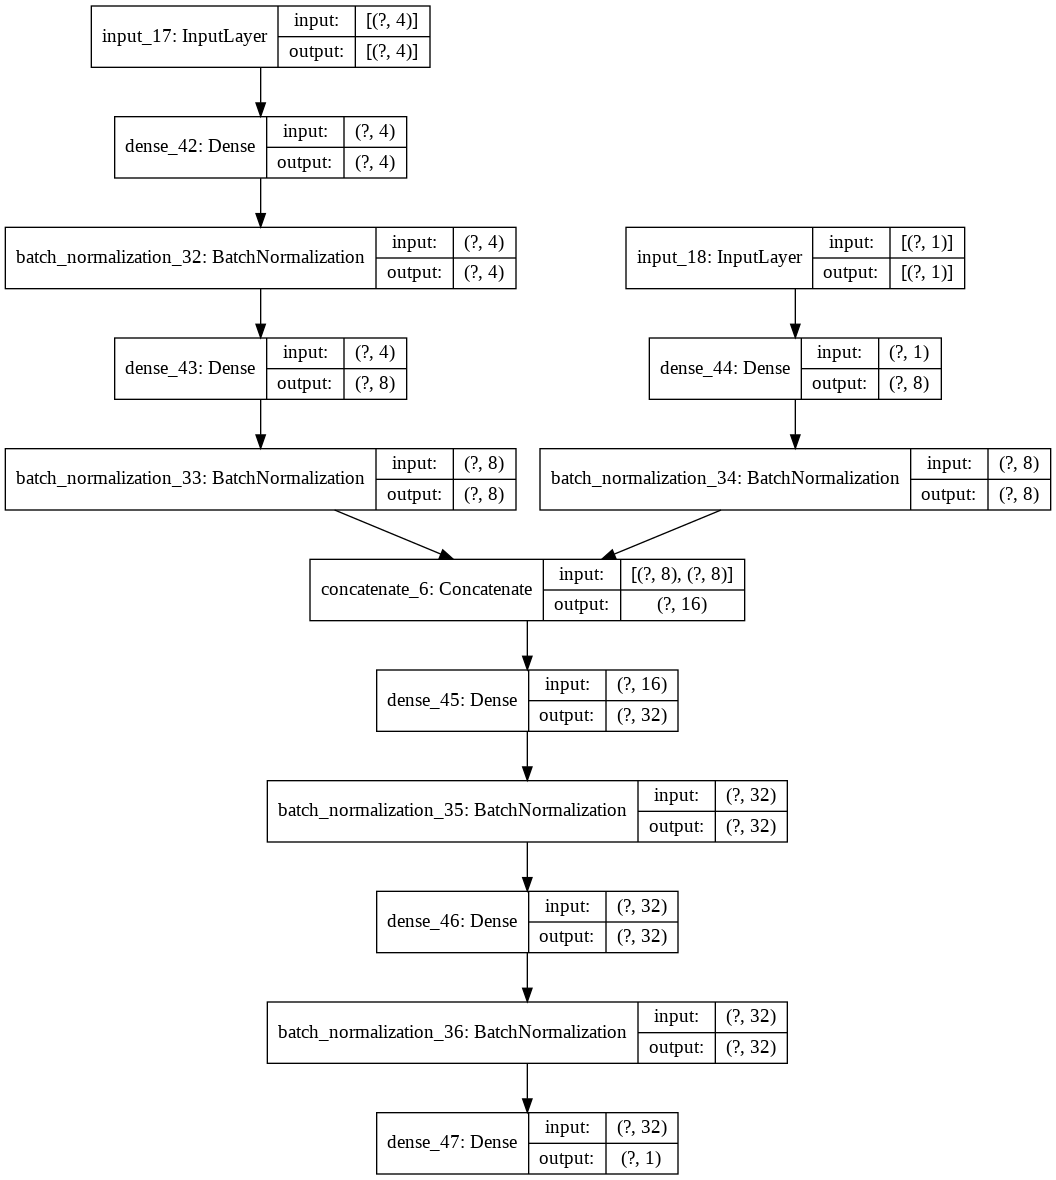

In [23]:
tf.keras.utils.plot_model(q_model,show_shapes=True,show_layer_names=True)

In [16]:
scores = []
for episode in range(1000):
    done = False
    total_reward=0
    state = env.reset()
    state = np.reshape(state, [1, state_num])
    while not done:
        next_state, reward, done, _=env.step(env.action_space.sample())
        total_reward += reward
    scores.append(total_reward)

16.599


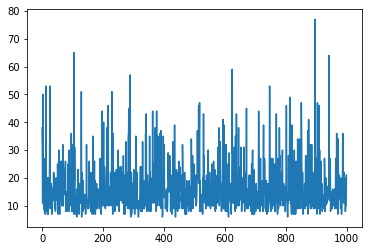

In [17]:
import matplotlib.pyplot as plt
plt.plot(scores)
print(np.mean(scores))

In [24]:
# 에피소드 수만큼 학습
episode_count=1000

# 점수를 기록할 리스트
scores = []

# 디스카운트 팩터 정의
discount_rate=0.99
batch_size=256
tau=0.1

# eps_mean=0.
# eps_std=0.1
# eps_theta=0.1
# eps_dt=0.01
# eps=0

state_list=collections.deque(maxlen=1000)
action_list=collections.deque(maxlen=1000)
reward_list=collections.deque(maxlen=1000)
next_state_list=collections.deque(maxlen=1000)
done_list=collections.deque(maxlen=1000)

for episode in range(episode_count):
    state = env.reset()
    # 차원을 맞추어 준다
    
    done = False
    total_reward = 0
    while not done:
        # noise=eps + eps_theta*(eps_mean-eps)*eps_dt + eps_std*np.sqrt(eps_dt)*np.random.normal(size=1)
        noise=np.random.normal(size=1)
        _state = np.reshape(state, [1, state_num])
        action=u_model.predict(_state)[0]  + noise
        # eps=noise
        
        action=np.clip(action,-1.0,1.0)
        
        next_state, reward, done, _ = env.step(action)
        state_list.append(state)
        action_list.append(action)     
        reward_list.append(reward)
        next_state_list.append(next_state)
        done_list.append(1-done)

        total_reward += reward
        state = next_state
        
        if len(state_list) >= batch_size:
            sample=random.sample(range(len(state_list)),batch_size)
            _state_list = tf.convert_to_tensor(np.array(state_list)[sample])
            _action_list = tf.convert_to_tensor(np.array(action_list)[sample])
            _reward_list = tf.convert_to_tensor(np.array(reward_list, dtype='float32')[sample])
            _done_list = tf.convert_to_tensor(np.array(done_list, dtype='float32')[sample])
            _next_state_list = tf.convert_to_tensor(np.array(next_state_list)[sample])
            
            with tf.GradientTape() as tape:
                q=q_model([_state_list,_action_list])
                n_a=t_u_model(_next_state_list)
                n_q=t_q_model([_next_state_list,n_a])
                tde=_reward_list + discount_rate * _done_list * tf.reshape(n_q,(batch_size,)) - tf.reshape(q,(batch_size,))
                q_loss=tf.math.square(tde)
                q_loss=tf.math.reduce_mean(q_loss)           
            q_grad=tape.gradient(q_loss,q_model.trainable_variables)
            opt_2.apply_gradients(zip(q_grad,q_model.trainable_variables))

            with tf.GradientTape() as tape:
                a=u_model(_state_list)
                q=q_model([_state_list,a])
                l=-tf.math.reduce_mean(q)
            u_grad=tape.gradient(l,u_model.trainable_variables)
            opt.apply_gradients(zip(u_grad,u_model.trainable_variables))
        
        if(total_reward>=200):
            done=True
            

        new_weights = []
        target_variables = t_q_model.weights
        for i, variable in enumerate(q_model.weights):
            new_weights.append(variable * tau + target_variables[i] * (1 - tau))

        t_q_model.set_weights(new_weights)

        new_weights = []
        target_variables = t_u_model.weights
        for i, variable in enumerate(u_model.weights):
            new_weights.append(variable * tau + target_variables[i] * (1 - tau))

        t_u_model.set_weights(new_weights)

    scores.append(total_reward)
    print(episode+1,total_reward)

env.close() 

1 16.0
2 23.0
3 7.0
4 10.0
5 12.0
6 18.0
7 7.0
8 10.0
9 7.0
10 7.0
11 28.0
12 14.0
13 14.0
14 10.0
15 17.0
16 11.0
17 11.0
18 13.0
19 24.0
20 13.0
21 15.0
22 8.0
23 7.0
24 8.0
25 6.0
26 7.0
27 6.0
28 8.0
29 5.0
30 8.0
31 10.0
32 9.0
33 7.0
34 10.0
35 8.0
36 7.0
37 6.0
38 8.0
39 8.0
40 7.0
41 8.0
42 10.0
43 5.0
44 7.0
45 6.0
46 6.0
47 7.0
48 9.0
49 11.0
50 7.0
51 8.0
52 5.0
53 9.0
54 6.0
55 7.0
56 6.0
57 6.0
58 6.0
59 10.0
60 7.0
61 7.0
62 6.0
63 7.0
64 8.0
65 6.0
66 10.0
67 7.0
68 11.0
69 6.0
70 9.0
71 8.0
72 6.0
73 8.0
74 7.0
75 8.0
76 7.0
77 12.0
78 9.0
79 8.0
80 22.0
81 18.0
82 25.0
83 40.0
84 128.0
85 58.0
86 36.0
87 185.0
88 36.0
89 62.0
90 6.0
91 68.0
92 126.0
93 133.0
94 138.0
95 96.0
96 42.0
97 152.0
98 24.0
99 31.0
100 8.0
101 50.0
102 8.0
103 42.0
104 15.0
105 10.0
106 26.0
107 68.0
108 129.0
109 99.0
110 43.0
111 87.0
112 131.0
113 109.0
114 200.0
115 118.0
116 107.0
117 97.0
118 102.0
119 9.0
120 106.0
121 192.0
122 22.0
123 156.0
124 150.0
125 93.0
126 105.0
127 47.0
128 9

KeyboardInterrupt: ignored

59.47482014388489


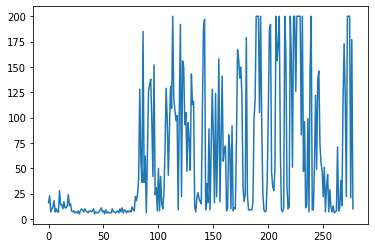

In [25]:
import matplotlib.pyplot as plt
plt.plot(scores)
print(np.mean(scores))